In this notebook, we'll try analyzing Sylas's data of beads in networks using methods described in this [Cho et al 2020 PRL paper](https://link.aps.org/doi/10.1103/PhysRevLett.124.088005).

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font_plt = {'family': 'serif','color':  'darkred','weight': 'normal','size': 8,}
font_plt_ax = {'family': 'serif','color':  'black','weight': 'normal', 'size': 8,}

In [2]:
import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
from scipy.optimize import leastsq
import pickle #for saving data

tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [3]:
reload(ddm) 

<module 'ddm_clean' from 'ddm_clean.pyc'>

In [103]:
#Specify where the data is stored and the image data filename. Must be in tiff format
data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\19_10_15_Entangled\\DDM\\_1\\"

########################
# Select Movie Number  #
########################
movie_num = 1

data_file = "_%i_MMStack_Pos0.ome.tif" % movie_num

<IPython.core.display.Javascript object>


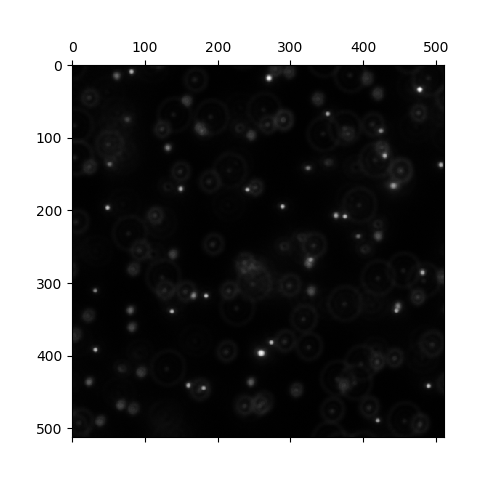

In [102]:
#Image read using tiff_file module
im = ddm.tiff_file.imread(data_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

### Open up the previosly generated DDM matrix data

In [104]:
########### Select ROI here ###############
ROI = 1   # <---- select ROI (0,1,2, or 3)
###########################################

data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\19_10_15_Entangled\\DDM\\analysis\\"
data_file = "_%i_MMStack_Pos0.ome_%i_256x256_FFTDIFFS_dts_ravs.p" % (movie_num, ROI)
f = open(data_dir + data_file,'rb')
p_data = pickle.load(f)
f.close()
print("The 'keys' contained in this pickle'd dictionary are: ", p_data.keys())

("The 'keys' contained in this pickle'd dictionary are: ", ['dts', 'ravs', 'ffts'])


In [7]:
#copy over that data stored in the dictionary
ravs = p_data['ravs']
dts = p_data['dts']

In [8]:
fps = 10.0 #The frame rate the video data was recorded at. 
times = dts/fps #Create the list of delay times in units of seconds
pixel_size = 0.3596 #pixel size in microns
numPixels = 256 #number pof pixels in ROI
q = np.arange(0,numPixels/2)*2*np.pi*(1./(numPixels*pixel_size)) #Convert the spatial frequencies to wave vectors

<IPython.core.display.Javascript object>


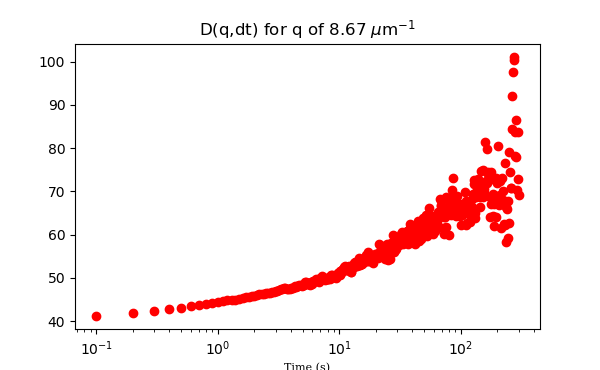

In [9]:
##########################################################################
# Here, we'll show the image structure function for a particular q-value. 
##########################################################################

qv=-1 # <-- this is the last q-value. useful for getting estimate of background
fig = plt.figure(figsize=(6,6./1.618))
plt.semilogx(times, ravs[:,qv],'ro')
ax = plt.gca()
plt.xlabel('Time (s)', fontdict=font_plt_ax);
plt.title("D(q,dt) for q of %.2f $\mu$m$^{-1}$" % q[qv]);


#### From above plot (or maybe from plotting D(q,dt) for other q values) estimate the background

In [10]:

backg = 20 #change me! <------------------------------------------


<IPython.core.display.Javascript object>


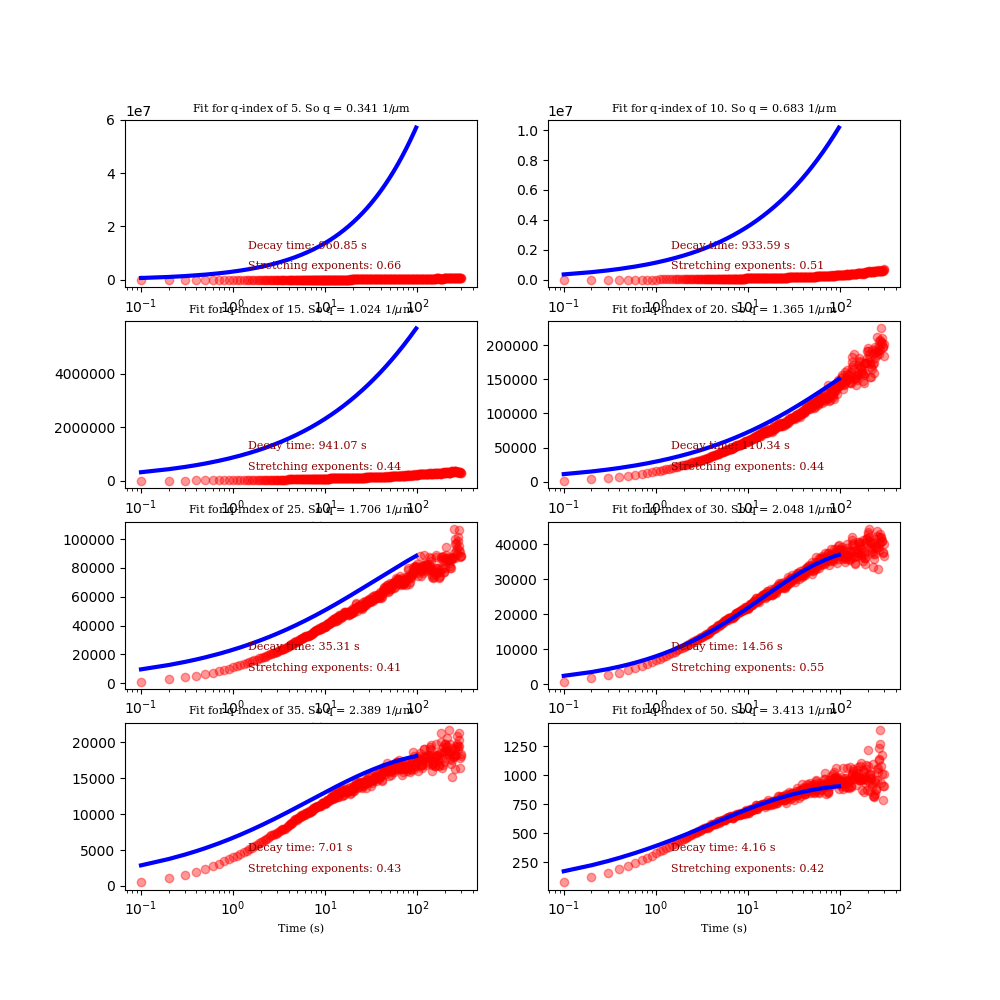

C:\ProgramData\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
mpfit.py:2284: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


bg: 0.001
bg: 0.001
bg: 0.001
bg: 0.001000000000000001
bg: 0.001000000000000002
bg: 0.001
bg: 0.0010000000000000078
bg: 0.001


In [11]:
def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''

    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=backg, double=False, fps=fps)
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp) - 3, (... same for second exp..))
    
    #Decay time
    # The initial guess for this parameter will be generated automatically
    # But here we can set the minimum and maximum of the possible values. 
    maxp[1] = 1000    #The decay time can't be larger than this
    minp[1] = 0.001   #The decay time can't be smaller than this
    
    #Background
    maxp[2]=400
    minp[2]=0.001
    pars[2]=backg #This was set in the previous code block
    
    #Stretching exponent. Ideally, this should be 1.0 (which would be a normal exponential)
    minp[3]=0.15   #Can't be smaller than this
    maxp[3]=1.01  #Can't be larger than this
    pars[3]=1.0  #The initial guess. Usually, this should be 1 unless you suspect anomalous behavior. 
    
    #We can choose to allow certain paramters to vary or we can fix them.
    # In the 'fix' vector, if we set to True, the value will be fixed and not allowed to vary.
    fix[3]= False  #Determines whether we fix alpha (the stretching exponent) or not
    fix[2]= False   #Determines whether we fix the background or not.
    

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

%matplotlib notebook
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)

q_index = 10  # 10 usually works because it tends to fit well for all types of dynamics
end_time = 300  # change this if the data plateaus early, it is where the fitting stops
#Loop over four different q-values to do the fit
for i,q_index in enumerate([5,10,15,20,25,30,35,50]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:end_time,q_index], times[:end_time])
    #print len(theoryB)
    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times[:len(theoryB)], theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.125,'Stretching exponents: %.2f' % (fitparamsB[3]), 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)

    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    print "bg:", fitparamsB[2]

In [12]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fitparams, theory, chi2 = two_rounds_fitting(ravs[:,i], times)
    amp[i] = fitparams[0]
    bg[i] = fitparams[2]
    tau[i] = fitparams[1]
    alph[i] = fitparams[3]

ddm_clean.py:243: RuntimeWarning: invalid value encountered in power
  g1 = np.exp(-1 * (x / t1)**s1)


<IPython.core.display.Javascript object>


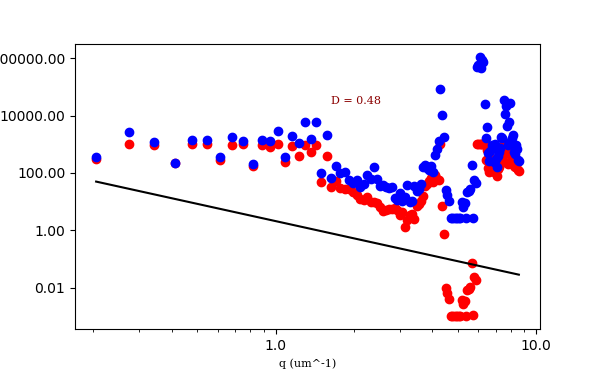

<IPython.core.display.Javascript object>


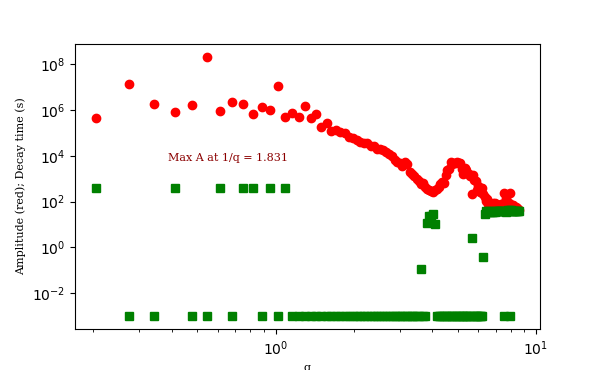

In [13]:
%matplotlib notebook

#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(6,6/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], tau[2:-1], 'ro')
ax.loglog(q[3:-1], ddm.newt(tau[2:-1],alph[2:-1]),'bo')
diffusion_coeff = 0.48
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**2), '-k')
ax.set_xlabel("q (um^-1)", fontdict=font_plt_ax)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.1f}'.format))
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.2f}'.format))
ax.text(0.55,0.8,'D = %.2f' % diffusion_coeff, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)

#Plot the amplitude versus the wave vector
fig = plt.figure(figsize=(6,6/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], amp[2:-1], 'ro')
w = amp[2:-1].argmax() #argmax returns the index of the array that has the max value
q_for_max_a = q[3:-1][w]
ax.loglog(q[3:-1], bg[2:-1], 'gs') #Plot the background versus the wave vector
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)
ax.text(0.2,0.6,'Max A at 1/q = %.3f' % (1.0/q_for_max_a), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);


## New method for getting A and B

First, make sure to select the correct ROI. Select it as either '0', '1', '2', or '3'

In [99]:

xi=[0, 256, 0, 256]
xf=[256, 512, 256, 512]
yi=[0, 0, 256, 256]
yf=[256, 256, 512, 512]
nframes, ndx, ndy = im[:,xi[ROI]:xf[ROI],yi[ROI]:yf[ROI]].shape
print("Our image has %i frames and each frame is %i x %i pixels" % (nframes, ndx,ndy))

Our image has 5000 frames and each frame is 256 x 256 pixels


In [16]:
#get the average abs(fft)^2 for each frame

av_fftsq_of_each_frame = np.zeros_like(im[0,xi[ROI]:xf[ROI],yi[ROI]:yf[ROI]]*1.0) #initialize array
for i in range(0, nframes):
    #looping over all frames in the movie
    fft_of_image = np.fft.fft2(im[i,xi[ROI]:xf[ROI],yi[ROI]:yf[ROI]]*1.0)
    sqr_of_fft = np.fft.fftshift(fft_of_image*np.conj(fft_of_image))
    av_fftsq_of_each_frame = av_fftsq_of_each_frame + abs(sqr_of_fft)
av_fftsq_of_each_frame = av_fftsq_of_each_frame/(1.0*nframes*ndx*ndy)

In [105]:
#get radially average
rad_av_av_fftsq = ddm.radialAvFFTs_v2(av_fftsq_of_each_frame.reshape(1,ndx,ndy))

data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\19_10_15_Entangled\\DDM\\analysis\\"
data_file = "_%i_MMStack_Pos0.ome_%i_256x256_rav_imageffts_for_AB.p" % (movie_num, ROI)
f = open(data_dir + data_file,'wb')
pickle.dump({'rad_av_av_fftsq': rad_av_av_fftsq}, f)
f.close()

<IPython.core.display.Javascript object>


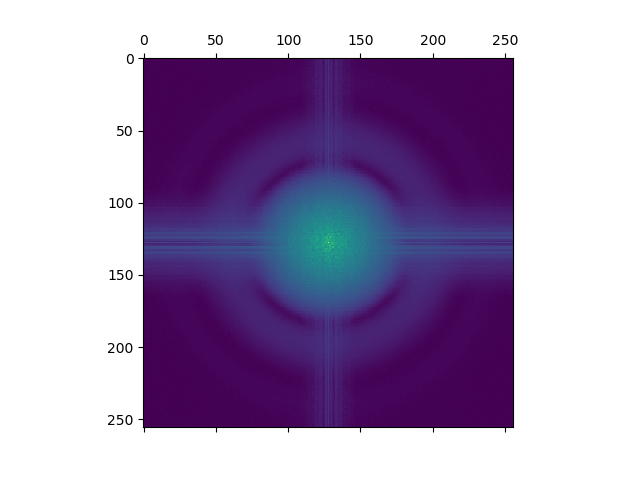

In [22]:
plt.figure()
plt.matshow(np.log(av_fftsq_of_each_frame),fignum=0)

<IPython.core.display.Javascript object>


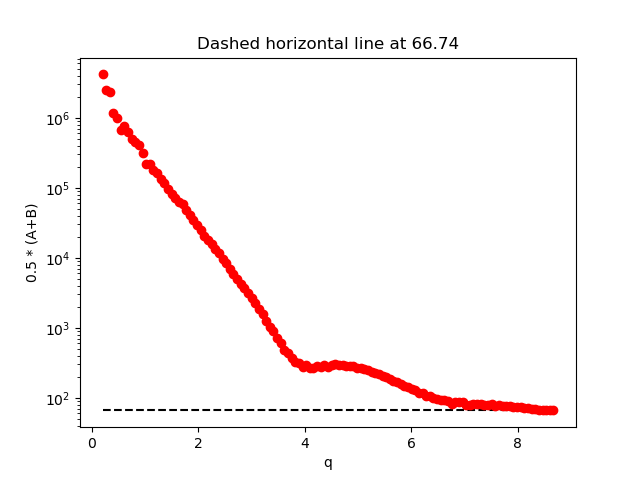

Text(0.5,1,'Dashed horizontal line at 66.74')

In [27]:
plt.figure()
plt.semilogy(q[3:], rad_av_av_fftsq[0,2:],'ro')
plt.xlabel("q")
plt.ylabel("0.5 * (A+B)")
plt.hlines(rad_av_av_fftsq[0,-1], q[3], q[-1], linestyles='dashed')
plt.title("Dashed horizontal line at %.2f" % rad_av_av_fftsq[0,-1])

Based off of the DDM data, I'd say the background is ~ 40. 
Based off the above plot, seems like it (1/2)(A+B) is plateauing at high q to around 50. So B is around 120. 

In [28]:
#Testing either 100 or 40 as background to use, seems 40 is better
background =40
new_amplitude = (2*rad_av_av_fftsq[0]) - background

<IPython.core.display.Javascript object>


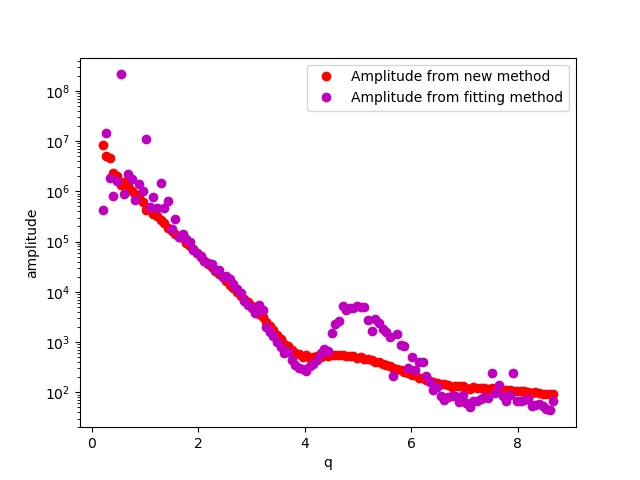

In [29]:
plt.figure()
plt.semilogy(q[3:], new_amplitude[2:], 'ro', label='Amplitude from new method')
plt.plot(q[3:], amp[2:], 'mo', label='Amplitude from fitting method')
plt.xlabel("q")
plt.ylabel("amplitude")
plt.legend(loc=0)

In [30]:
ravs.shape

(400L, 127L)

Based on our new value for amplitude, let's find the intermediate scattering function

In [31]:
#Just double checking sizes of arrays:
print("size of ravs array (the ddm matrix or image struct func): %i by %i" % ravs.shape)
print("size of new amplitudes: %i" % new_amplitude.shape)

size of ravs array (the ddm matrix or image struct func): 400 by 127
size of new amplitudes: 127


In [32]:
#Initialize arrays to store the ISF (intermediate scattering function)
isf = np.zeros_like(ravs) #decay time

for i in range(1,ravs.shape[1]):
    isf[:,i] = 1 - ((ravs[:,i] - background) / new_amplitude[i])

<IPython.core.display.Javascript object>


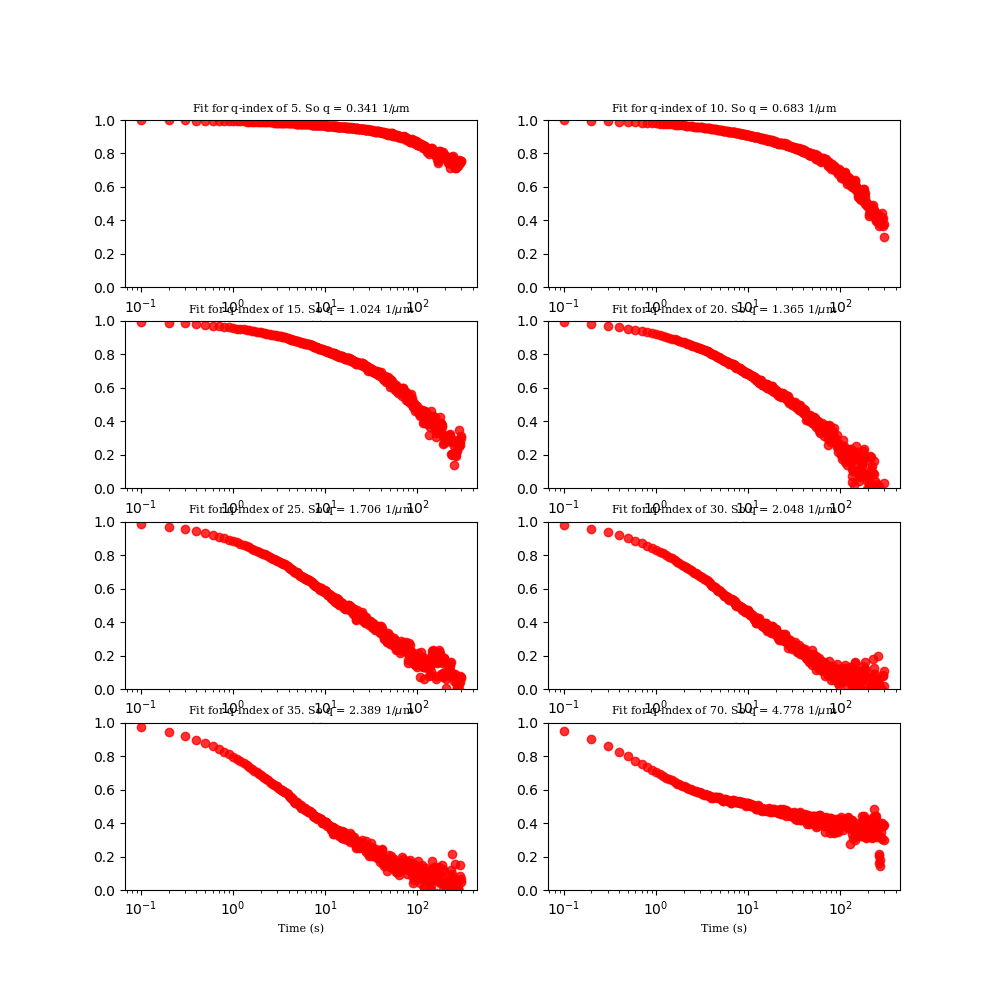

In [33]:
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)


#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([5,10,15,20,25,30,35,70]):

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,isf[:,q_index],'ro',alpha=0.8)
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    
    ax.set_ylim(0,1)

In [63]:
def errorfunc_for_scipy_leastsq_fit(params, data, times):
    theory = ddm.dTheoryNonErgISF(times, params[0],params[1],params[2])
    return data-theory
    

def isf_fitting(data, times):
    '''
    This function does the ISF fitting. 

    We'll just use one round. Using Levenberg-Marquardt method with the mpfit module. 
    '''
    
    #Our parameters are: c (non-ergodicity param), tau, stretching epxonent
    pars = np.zeros(3)*1.0
    minp = np.zeros_like(pars)
    maxp = np.zeros_like(pars)
    lmin = np.array([True, True, True])
    lmax = np.array([True, True, True])
    fix = np.array([False, False, False])
    
    #come up with limits:
    minp[0] = 0.0 #minimum non-erg parameter
    maxp[0] = 1.0 #maximum non-erg parameter
    minp[1] = 0.01 #minimum decay time
    maxp[1] = 3000.0  #maximum decay time
    minp[2] = 0.1 #minimum stretching exponent
    maxp[2] = 0.99 #maximum stretching exponent
    
    #initial guesses (maybe should use tau from earlier fits to D(q,t)?)
    pars[0] = 1.0 #non-ergodicity parameter
    pars[1] = 50.0 #decay time
    pars[2] = 0.65 #stretching exponent
    
    fitparams_lstsq_temp = leastsq(errorfunc_for_scipy_leastsq_fit, pars, args=(data,times))
    fitparams_isf_lstsq = fitparams_lstsq_temp[0]
    theory_isf_lstsq = ddm.dTheoryNonErgISF(times, fitparams_isf_lstsq[0], fitparams_isf_lstsq[1], fitparams_isf_lstsq[2])
    

    for i in [1,2]:
        if fitparams_isf_lstsq[i] > maxp[i]:
            pars[i] = 0.99*maxp[i]
        elif fitparams_isf_lstsq[i] < minp[i]:
            pars[i] = 1.01*minp[i]
        else:
            pars[i] = fitparams_isf_lstsq[i]
    if fitparams_isf_lstsq[0]>0:
        if fitparams_isf_lstsq[0]<1.0:
            pars[0] = fitparams_isf_lstsq[0]


    fitparams_isf, theory_isf, errCode, chi2 = ddm.newFit_ISF(data,times,pars,minp,maxp,lmin,lmax,fix,
                                                              logfit=False,quiet=True,factor=1)
    
    return fitparams_isf, theory_isf, chi2, fitparams_isf_lstsq, theory_isf_lstsq


<IPython.core.display.Javascript object>


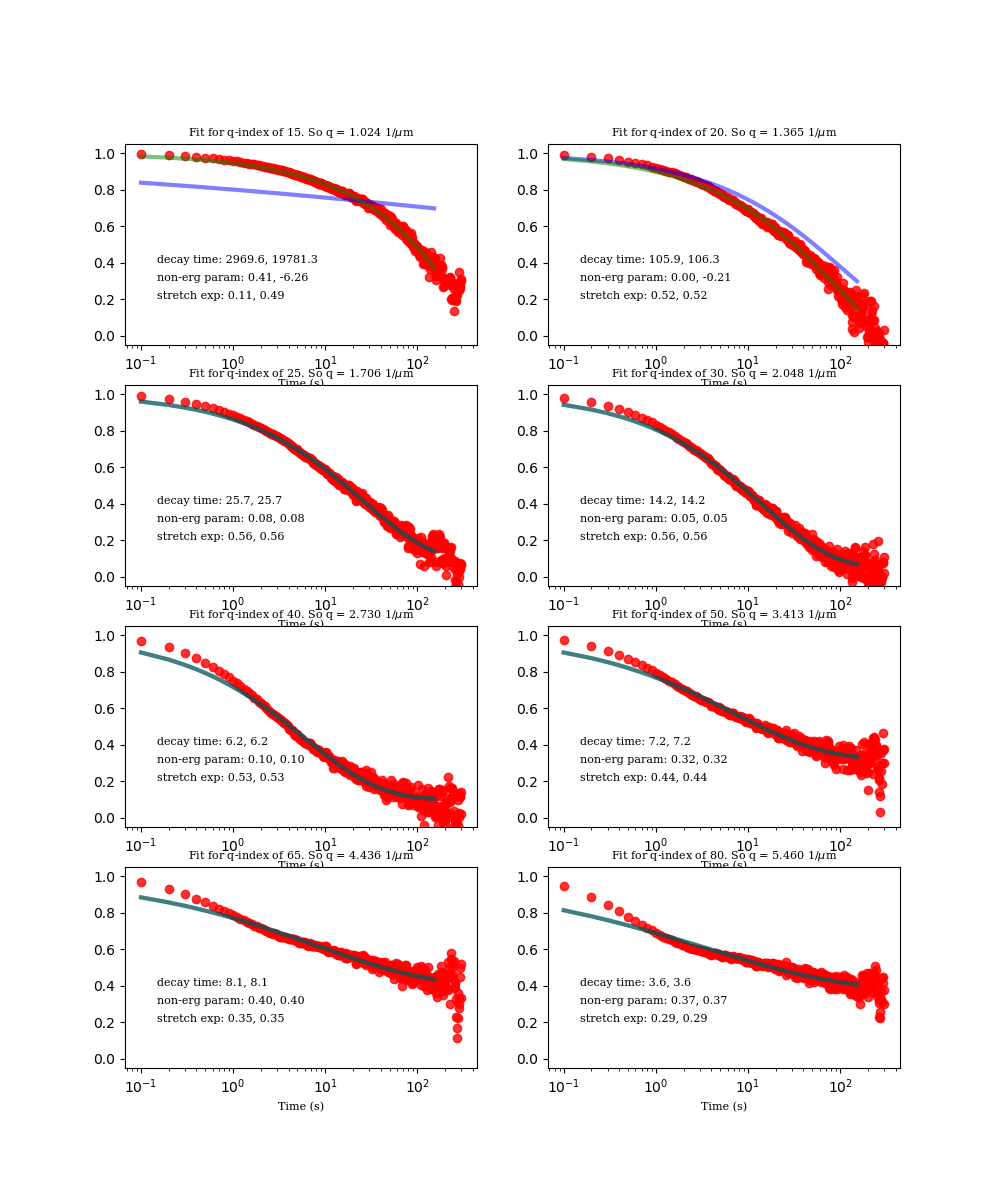

In [107]:
plt.figure(figsize=(10,12)) #Create figure of size 15x15 (inches)

last_time = -60 # ONLY FIT UP TO THIS FINAL TIME POINT

#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([15,20,25,30,40,50,65,80]):
    
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,q_index],times[:last_time])

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times[:],isf[:,q_index],'ro',alpha=0.8)
    ax.semilogx(times[:last_time], theory_isf, '-b',lw=3,alpha=0.5) #BLUE LINE: Leven-Marq fitting method
    ax.semilogx(times[:last_time], theory_isf_lstsq,'-g',lw=3,alpha=0.5) #GREEN LINE: scipy.optimize's leastsquares function
    
    ax.text(0.15,0.4, "decay time: %.1f, %.1f" % (fp_isf[1], fp_isf_lstsq[1]), fontdict=font_plt_ax)
    ax.text(0.15,0.3, "non-erg param: %.2f, %.2f" % (fp_isf[0], fp_isf_lstsq[0]), fontdict=font_plt_ax)
    ax.text(0.15,0.2, "stretch exp: %.2f, %.2f" % (fp_isf[2], fp_isf_lstsq[2]), fontdict=font_plt_ax)
    
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    ax.set_ylim(-0.05,1.05)
    
plt.savefig(data_dir+data_file[:-2]+"_ISF.png",dpi=150)

In [66]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau_v2 = np.zeros_like(ravs[0,:]) #decay time
c = np.zeros_like(tau) #amplitude
alph_v2 = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:,i],times)
    c[i] = fp_isf[0]
    tau_v2[i] = fp_isf[1]
    alph_v2[i] = fp_isf[2]

<IPython.core.display.Javascript object>


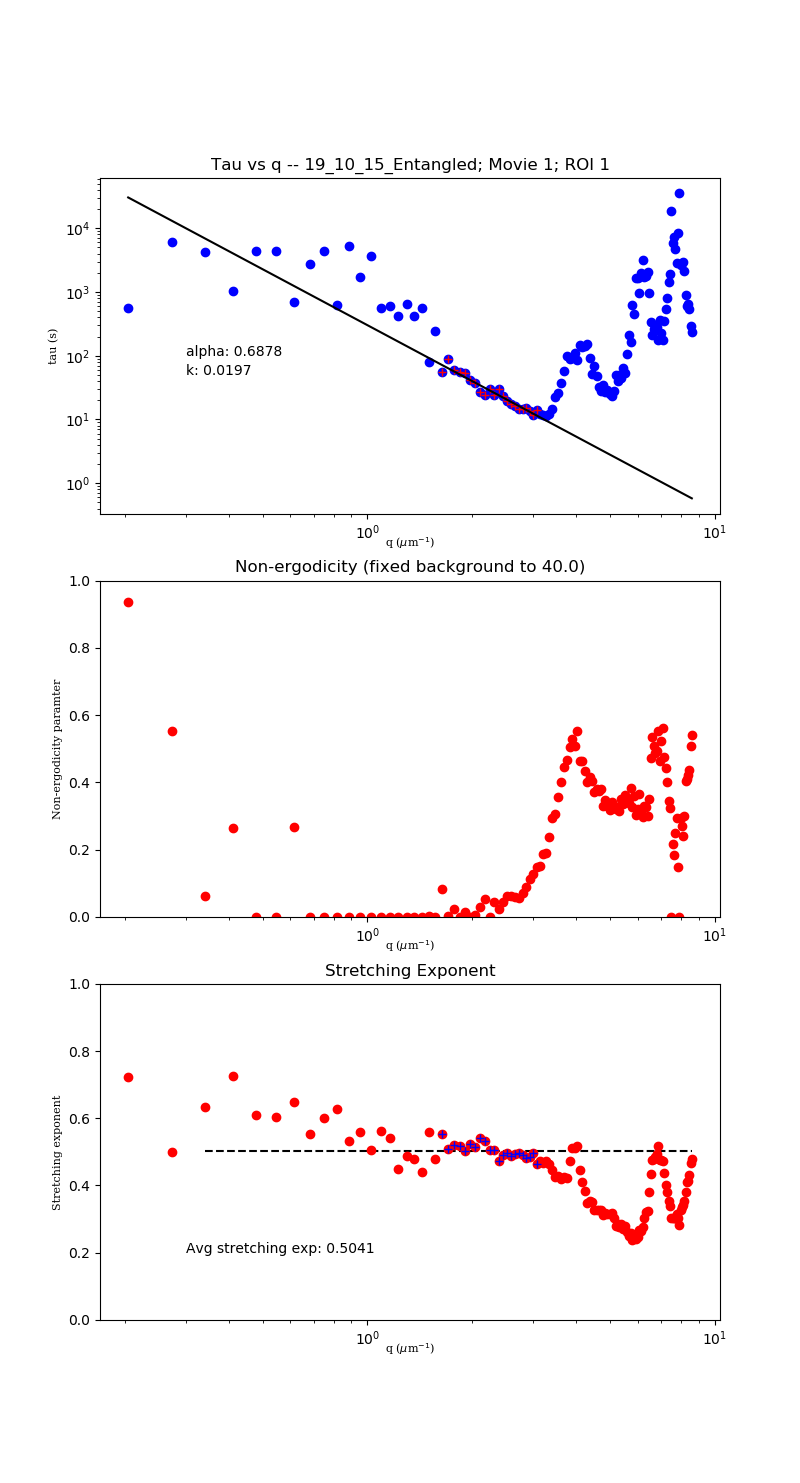

In [106]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,3*8/1.618)); ax = fig.gca();
ax = plt.subplot(3,1,1)

plt.title("Tau vs q -- " + data_dir.split('\\')[-4] + "; Movie " + str(movie_num) + "; ROI " + str(ROI))
qs=q[3:-1]
new_taus=ddm.newt(tau_v2[2:-1],alph_v2[2:-1])
ax.loglog(qs, new_taus,'bo')
minq=21
maxq=42
qmin=qs[minq]
qmax=qs[maxq]
b = np.where((qs>=qmin)&(qs<=qmax))
ax.plot(qs[b[0]],new_taus[b[0]],'r+')
a = np.polyfit(np.log(qs[b[0]]),np.log(new_taus[b[0]]), 1)
slope = a[0]
coef1 = np.exp(a[1])
alpha = 2./(-1*slope)
Dif = (1.0/coef1)**alpha
tau_fit = coef1*(qs**(-2.0/alpha))
ax.plot(qs, tau_fit, '-k')

ax.text(0.3,100, "alpha: %.4f" % alpha)
ax.text(0.3,50, "k: %.4f" % Dif)

ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
#k = 0.01
#ax.plot(q[3:-1], (1./k) * 1./(q[3:-1]**3), '-k')


#Plot the non-erg parameter versus the wave vector
ax = plt.subplot(3,1,2)
plt.title("Non-ergodicity (fixed background to %.1f)" % background)
ax.semilogx(q[3:-1], c[2:-1], 'ro')
ax.set_ylim(0,1)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Non-ergodicity paramter", fontdict=font_plt_ax)

#Plot the stretching exponent versus the wave vector
ax = plt.subplot(3,1,3)
plt.title("Stretching Exponent")
ax.semilogx(q[3:-1], alph_v2[2:-1], 'ro')
ax.plot(qs[b[0]],alph_v2[2:-1][b[0]],'b+')
ax.hlines(alph_v2[2:-1][b[0]].mean(), qs[2],qs[-1], linestyles='dashed')
ax.text(0.3,0.2,"Avg stretching exp: %.4f" % alph_v2[2:-1][b[0]].mean())
ax.set_ylim(0,1)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Stretching exponent", fontdict=font_plt_ax)


plt.savefig(data_dir+data_file[:-2]+"_tauvsq_nonergparam.png",dpi=150)

In [95]:
data_file

'_1_MMStack_Pos0.ome_1_256x256_rav_imageffts_for_AB.p'